# Lab 3 — dimensionality reduction
**Internet Analytics - Lab 3**

---

**Group:** *K*

**Names:**

* *Robin Lang*
* *Kim Lan Phan Hoang*

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

from operator import itemgetter

%matplotlib inline
plt.style.use("ggplot")

relevance_file_name = "relevance_array.npy"

## TESTS PLEASE DELETE

``` !hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 2 ```

In [ ]:
movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
tags = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
data = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)
#tag2name = dict(data.map(itemgetter("tagId", "tag")).collect())

In [ ]:
data.filter(lambda x: x["movieId"]==1 & x["tagId"]==1).take(1)

In [ ]:
tags.take(10)

In [ ]:
scoresByTag = data.groupBy(lambda x: x["tagId"])

In [ ]:
scoresByTag.take(10)

---

**construct ratings array**

In [88]:
# relaunch!! may contain error!!

In [ ]:
n_movies = movies.map(lambda x: x["movieId"]).max()
n_tags = tags.map(lambda x: x["tagId"]).max()

In [ ]:
print("movies:", n_movies, "| tags:", n_tags)

In [ ]:
relevance_array = np.zeros((n_tags, n_movies), dtype=float)

for i in data.toLocalIterator():
    relevance_array[i["tagId"]-1][i["movieId"]-1] = i["relevance"]

**save to file**

In [ ]:
np.save(relevance_file_name, relevance_array)

**open existing array file**

In [2]:
relevance_array_load = np.load(relevance_file_name)

## Exercice 3.1

### Plot the variance of each dimension / tag.

In [3]:
rel_var = []
for i in relevance_array_load:
    rel_var.append(np.var(i))

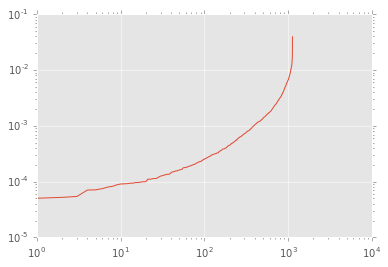

In [4]:
plt.loglog(sorted(rel_var))


### Plot the eigenvalues of the covariance matrix.

In [28]:
rel_cov = np.cov(relevance_array_load)
rel_eigvals, rel_eigvecs = la.eigh(rel_cov)

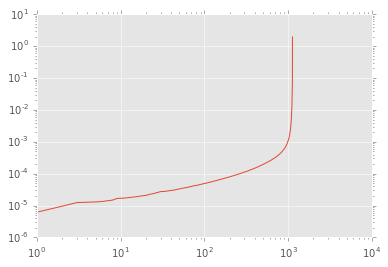

In [29]:
plt.loglog(rel_eigvals)

### Explain the implications for dimensionality reduction.

Dimensionality reduction means you take some principal directions and project the data onto them. <br>
By doing this you effectively lose some precision, however the dimension of the data can often be greatly decreased, improving performance.

**How many principal directions do you need to capture $2 \over 3$ of the variability in the data?**

In [30]:
sum_eig = sum(rel_eigvals)
s = 0
n_eigvals = len(rel_eigvals)
index = 0

while s < sum_eig*2/3:
    s += rel_eigvals[n_eigvals-index-1]
    index += 1

print("to capture 2/3 of the variability you need", index, "principal directions")

to capture 2/3 of the variability you need 3 principal directions


## Exercice 3.2

### For the five first principal directions, find the 10 tags that have the highest and lowest coordinates in that direction.

In [45]:
# first 5 principle directions (i think anyway)
rel_dirs = []
for i in range(5):
    rel_dirs.append(rel_cov @ rel_eigvecs[-i-1])

In [65]:
def find_tags(tags, direction):
    N = len(tags)
    
    scores = np.zeros(N)

    for i in range(N):
        scores[i] = np.dot(tags[i], direction)
    
    top10 = np.argsort(-scores)[:10]
    bottom10 = np.argsort(scores)[:10] # bottom 10 are always 0, as there are empty tags, where all entries are 0
    
    print("top10:", top10+1)
    print("bottom10:", bottom10+1)

In [66]:
find_tags(relevance_array_load.T, rel_dirs[0])

top10: [   318   2571   2959 112582  27667  40697   4226     50 119139   4878]
bottom10: [131262  84564  84563  84562  84561  84560  84559  84558  84557  84556]


### What concepts would you use to describe these dimensions?

WHAT??

## Exercice 3.3

### Create an interactive plot that displays the 2D-projection of the movies using bokeh and its hover tool. Color the nodes by their Rotten Tomatoes score.

### Explain the coordinates of a few of the movies.

### How do the PCA directions correlate with the Rotten Tomatoes score?

In [ ]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()